In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(1, '/content/drive/My Drive/Side Project/Topology')

In [3]:
from dataset import ETL
from test import test

In [ ]:
!unzip -uq "/content/drive/My Drive/Side Project/Topology/data/training_data.zip"
!unzip -uq "/content/drive/My Drive/Side Project/Topology/data/training_data_2.zip"

replace data/F/FX_17500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
data = ETL()
data.blur = False
data.initiate(augment = False)
train_data = data.train_images

Loading DATA.........

Loading CompTime data.........



  0%|          | 29/20375 [00:00<01:11, 285.90it/s]



Loading images.........



100%|██████████| 20375/20375 [00:46<00:00, 433.82it/s]


cleaning data.....



In [ ]:
totalNum = train_data.shape[0]
K = np.random.randint(1, totalNum+1, 200)
test_images = train_data[K,:,:,:]
Kdiff = np.setdiff1d(np.arange(0,totalNum),K)
train_images = train_data[Kdiff,:,:,:]

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
IMG_SHAPE = [train_images.shape[1],train_images.shape[2]]
print(train_images.shape)

(19150, 32, 64, 6)


In [ ]:
def generate_and_save_images(epoch,test_images,gen,disc):
  viz = Visualization(gen,disc)
  viz.noise_dim = noise_dim
  fig = plt.figure(figsize=(10,3*len(test_images)/2))
  pred = viz.generate_images(test_images)

  plt.savefig("/content/drive/My Drive/Colab Notebooks/HGAN/"+"image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

In [ ]:
from utility import utils
from layer_blocks import blocks
Util = utils()
Block = blocks()

# MODEL 

In [ ]:
input_dim = (train_images.shape[1],train_images.shape[2],train_images.shape[3]-1)
sol_dim = (train_images.shape[1],train_images.shape[2],1)
noise_dim = 100
import numpy as np
print(input_dim,sol_dim)

(32, 64, 5) (32, 64, 1)


In [ ]:
def generator(ndim = noise_dim, pbdim = input_dim):

  noise = layers.Input(shape = ndim)
  inpimg = layers.Input(shape = pbdim)#64,196
  filters = 256
  x = Util.FcLayer_Reshape(x = noise,out = [2,4,filters])#1,2
  
  for i in range(1,5):
    sh = [2**i,2**(i+1)]
    x = Block.SPADE_ResBlock(x,Util.Resize(inpimg,sh[0],sh[1]),filters = filters/2,current_filters = filters,s=3, con = True)
    filters= filters/2
    x = Util.UpPool(x)#2,4
  
  x = Block.Conv_block(x,1,s=3,act ='tanh',nm = None)
  return tf.keras.Model(inputs= [noise,inpimg], outputs = x, name="generator")

In [ ]:
gen = generator()
gen.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         206848      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048)         8192        dense[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 2048)         0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [ ]:
def critic(sd = sol_dim, inp = input_dim):
  initializer = tf.random_normal_initializer(0., 0.02)

  sol = layers.Input(shape = sd)
  inpimg = layers.Input(shape = inp)
  x = layers.Concatenate()([sol,inpimg])
  fr = 64
  z = []
  for i in range(4):
    x = Block.Conv_block(x,fr,4,scale = 'down')
    fr = 2*fr
    z.append(x)

  x = layers.Flatten()(x)
  x = Util.FcLayer(x,1, act = 'sigmoid')

  return tf.keras.Model(inputs= [sol,inpimg], outputs = [x,z], name="critic")


In [ ]:
disc = critic()
disc.summary()

Model: "critic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32, 64, 5)]  0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 32, 64, 6)    0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 32, 64, 64)   6208        concatenate_8[0][0]         

In [ ]:
from viz import Visualization

0.7198305130004883
100


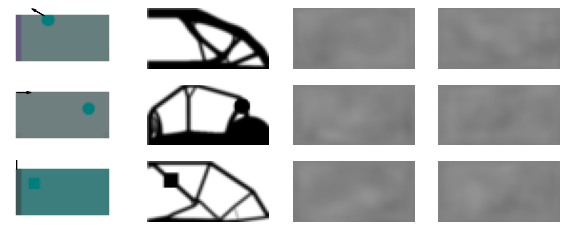

In [ ]:
import time
import matplotlib.pyplot as plt

start = time.time()
plt.figure(figsize=(10,4))  
viz = Visualization(gen,disc)
viz.noise_dim = noise_dim
img = test_images[0:3,:,:,:]
viz.generate_images(img) 
print(time.time()-start)
print(viz.noise_dim)

# Training GAN

In [ ]:
# def gradient_penalty(bs,inpimg,sol,fake_images,):
#     interpolated = []
#     alpha = tf.random.normal([bs, 1, 1, 1], 0.0, 1.0)

#     diff = fake_images - sol
#     interpolated = sol + alpha * diff      
      
#     with tf.GradientTape() as gp_tape:
#          gp_tape.watch(interpolated)
#          pred = disc([interpolated,inpimg], training=True)

#     grads = gp_tape.gradient(pred, [interpolated,inpimg])[0]
#     norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
#     gp = tf.reduce_mean((norm - 1.0) ** 2)

#     return gp

In [ ]:
import datetime

dir = "/content/drive/My Drive/Colab Notebooks/HGAN/"
log_dir= dir

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0,beta_2=0.99)
discriminator_optimizer = tf.keras.optimizers.Adam(4e-4,beta_1=0,beta_2=0.99)

In [ ]:
from test import test
T = test()
T.initiate()

def test_acc(real,fake,pb):
    z = []
    fake = np.array(fake)
    real = np.array(real)
    pb = np.array(pb)

    for i in range(real.shape[0]):
        r = real[i:i+1,:,:,:]
        f = fake[i:i+1,:,:,:]
        p = pb[i:i+1,:,:,:]
        z.append(T.test(r,f,p))
    
    z = np.array(z)
    zm = np.median(z,axis = 0)
    return zm,z


In [ ]:
import os
checkpoint_dir = dir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 gen = gen,
                                 disc = disc)

In [ ]:
@tf.function
def fn():
  with tf.init_scope():
    print(tf.executing_eagerly())
  #print(tf.executing_eagerly())
fn()

True


In [ ]:
def comp_gen_loss(fake_img):
  #gen_loss = -tf.reduce_mean(fake_img)
  gen_loss = B(tf.zeros_like(fake_img),fake_img)
  return gen_loss

In [ ]:
def comp_disc_loss(real_img,fake_img):
  #real_loss = tf.reduce_mean(real_img)
  #fake_loss = tf.reduce_mean(fake_img)
  real_loss = B(tf.zeros_like(real_img),real_img)
  fake_loss = B(tf.ones_like(fake_img),fake_img)
  return fake_loss,real_loss

In [ ]:
L1 = tf.losses.MeanAbsoluteError()
L2 = tf.losses.MeanSquaredError()
B = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def feature_loss(fake,real):
  loss = 0
  for f,r in zip(fake,real):
    loss = loss + L1(f,r)
  return loss

In [ ]:
#@tf.function
def train_step(images,epoch):

    bs = tf.shape(images)[0]    
    inpimg = images[:,:,:,1:6]
    sol = images[:,:,:,0:1]


    with tf.GradientTape() as disc_tape,tf.GradientTape() as gen_tape:
         noise = tf.random.normal([bs, noise_dim])

          # PREDICTION------------------
         fake_images = gen([noise,inpimg],training=True)
         real_output, real = disc([sol,inpimg], training=True)
         fake_output, fake = disc([fake_images,inpimg], training=True)

          # DISC LOSS------------------
         real_loss, fake_loss = comp_disc_loss(real_output,fake_output)
         total_disc_loss = fake_loss + real_loss 

          # GEN LOSS------------------------
         L1_loss = L1(sol,fake_images)

         gen_loss = comp_gen_loss(fake_output)
         total_gen_loss = gen_loss + feature_loss(fake,real)
          ## APPLY GRAD
    gradients_of_discriminator = disc_tape.gradient(total_disc_loss, disc.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))

    gradients_of_generator = gen_tape.gradient(total_gen_loss, gen.trainable_variables)  
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))   

    with summary_writer.as_default():
      tf.summary.scalar('gen_loss',total_gen_loss, step=epoch)
      tf.summary.scalar('disc_loss',total_disc_loss, step=epoch)
      tf.summary.scalar('L1_loss', L1_loss, step=epoch)

    return gen_loss,real_loss,fake_loss,total_gen_loss,total_disc_loss,L1_loss
  

In [ ]:
def train(dataset,epochs,test_case):
  Loss_mat = []
  test_mat = []  


  for epoch in range(epochs):
    start = time.time()
  
    for image_batch in dataset:
      
      loss_train = train_step(image_batch,epoch)
 
    # DETERMINING AVG LOSS
    Loss_mat.append(loss_train)
    loss_epoch = np.asarray(loss_train)

    # Test 
    noise = tf.random.normal([test_images.shape[0], noise_dim])
    pb = test_images[:,:,:,1:6]

    fake = gen([noise,pb],training=False)
    real = test_images[:,:,:,0:1]

    test_epoch,_ = test_acc(real,fake,pb)
    test_L1 = L1(real,fake)

    test_mat.append([test_epoch[0],test_epoch[1],test_L1])


    # SAVE THE BEST MODEL ONLY
    #loss_epoch = numpy.array(loss_epoch)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      print('MODEL SAVED')
    
    display.clear_output(wait=True)
    generate_and_save_images(epoch,test_case,gen,disc)
    print ('Time for epoch {} is {} sec: gen,real,fake,total_gen_,total_disc :{:.4},{:.4},{:.4},{:.4},{:.4}, L1: {:,.4} '.format(epoch + 1,time.time()-start,
            loss_epoch[0],loss_epoch[1],loss_epoch[2],loss_epoch[3],loss_epoch[4],loss_epoch[5]))
    print('Testing results: Vol loss- {:.4},Comp loss - {:.4},L1 Loss- {:.4}'.format(test_epoch[0],test_epoch[1],test_L1))
  
  display.clear_output(wait=True)
  generate_and_save_images(epoch,test_case,gen,disc)
  
  return Loss_mat,test_mat

In [ ]:
BATCH_SIZE = 200
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2],train_images.shape[3]).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(np.asarray(train_images)).batch(BATCH_SIZE)
test_case = test_images[np.random.randint(0,test_images.shape[0],4),:,:,:]
gen = generator()
disc = critic()

from IPython import display

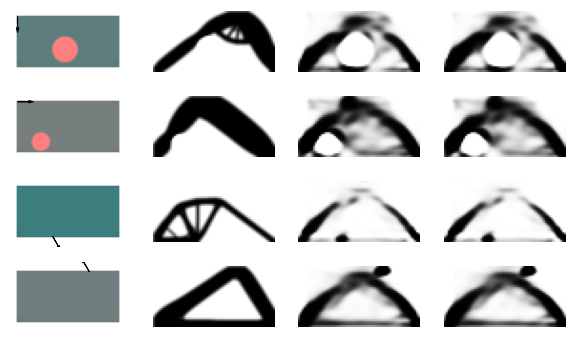

Time for epoch 28 is 75.61858224868774 sec: gen,real,fake,total_gen_,total_disc :0.9154,0.518,0.8171,1.789,1.335, L1: 0.4523 
Testing results: Vol loss- 0.07,Comp loss - -1.698e+03,L1 Loss- 0.4447


In [ ]:
EPOCH = 50  
Loss_mat,test_mat = train(train_dataset,EPOCH,test_case)

In [ ]:
Lp = np.array(Loss_mat)
#Lp = np.vstack((Lp,Loss_mat))

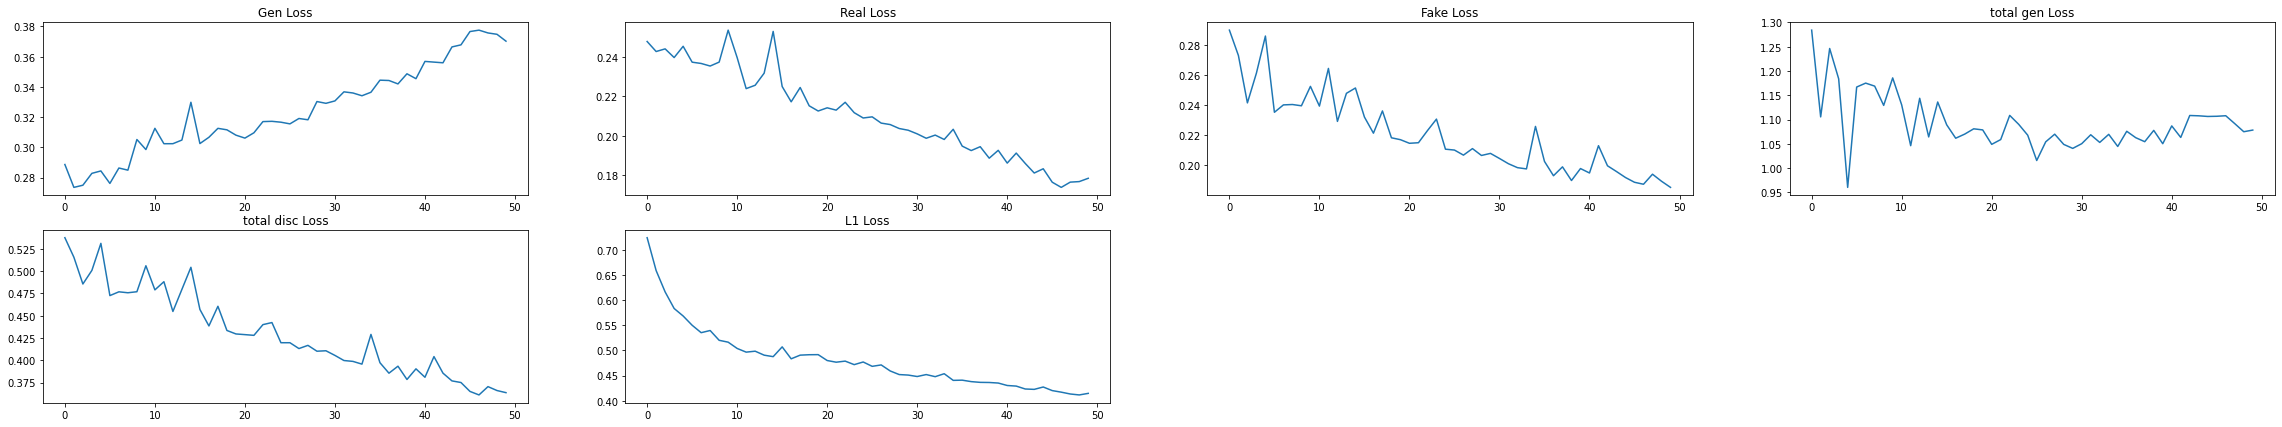

In [ ]:
#gen_loss,real_loss,fake_loss,total_gen_loss,total_disc_loss,L1_loss
plt.figure(figsize=(40,7))

plt.subplot(2,4,1)
plt.title('Gen Loss')
plt.plot(Lp[:,0])

plt.subplot(2,4,2)
plt.title('Real Loss')
plt.plot(Lp[:,1])

plt.subplot(2,4,3)
plt.title('Fake Loss')
plt.plot(Lp[:,2])

plt.subplot(2,4,4)
plt.title('total gen Loss')
plt.plot(Lp[:,3])

plt.subplot(2,4,5)
plt.title('total disc Loss')
plt.plot(Lp[:,4])

plt.subplot(2,4,6)
plt.title('L1 Loss')
plt.plot(Lp[:,5])


In [ ]:
Td = np.array(test_mat)

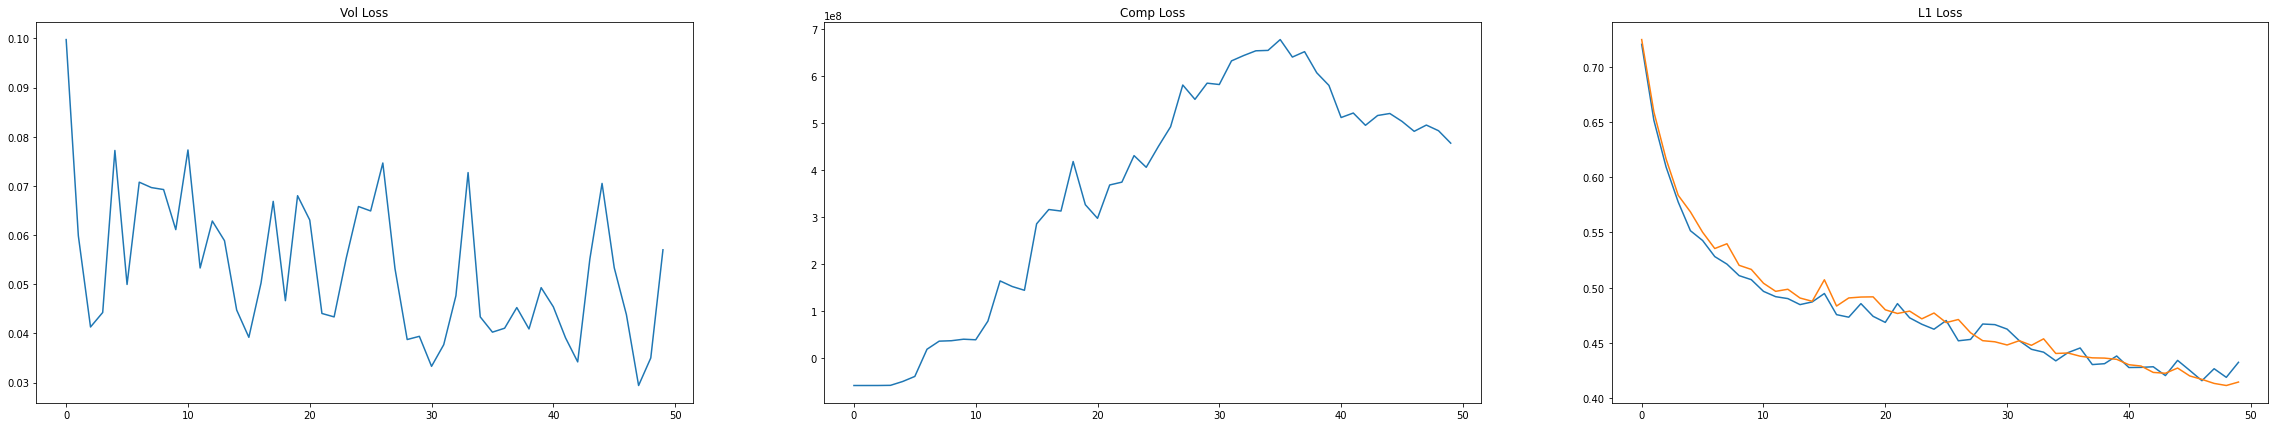

In [ ]:
plt.figure(figsize=(40,7))
plt.subplot(1,3,1)
plt.title('Vol Loss')
plt.plot(Td[:,0])

plt.subplot(1,3,2)
plt.title('Comp Loss')
plt.plot(-Td[:,1])

plt.subplot(1,3,3)
plt.title('L1 Loss')
plt.plot(Td[:,2])
plt.plot(Lp[:,5])

In [ ]:
import glob
import imageio
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob("/content/drive/My Drive/Colab Notebooks/HGAN/"+'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)



In [ ]:
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 8.3MB/s 


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
# import torch as nn 
# ## COMPLIANCE - CNN PREDICT

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [ ]:
# class Graph: 
  
#     def __init__(self, row, col, g): 
#         self.ROW = row 
#         self.COL = col 
#         self.graph = g 
  
#     # A function to check if a given cell  
#     # (row, col) can be included in DFS 
#     def isSafe(self, i, j, visited): 
#         # row number is in range, column number 
#         # is in range and value is 1  
#         # and not yet visited 
#         return (i >= 0 and i < self.ROW and 
#                 j >= 0 and j < self.COL and 
#                 not visited[i][j] and self.graph[i][j]) 
              
  
#     # A utility function to do DFS for a 2D  
#     # boolean matrix. It only considers 
#     # the 8 neighbours as adjacent vertices 
#     def DFS(self, i, j, visited): 
  
#         # These arrays are used to get row and  
#         # column numbers of 8 neighbours  
#         # of a given cell 
#         rowNbr = [-1, -1, -1,  0, 0,  1, 1, 1]; 
#             colNbr = [-1,  0,  1, -1, 1, -1, 0, 1]; 
          
#         # Mark this cell as visited 
#         visited[i][j] = True
  
#         # Recur for all connected neighbours 
#         for k in range(8): 
#             if self.isSafe(i + rowNbr[k], j + colNbr[k], visited): 
#                 self.DFS(i + rowNbr[k], j + colNbr[k], visited) 
  
  
#     # The main function that returns 
#     # count of islands in a given boolean 
#     # 2D matrix 
#     def countIslands(self): 
#         # Make a bool array to mark visited cells. 
#         # Initially all cells are unvisited 
#         visited = [[False for j in range(self.COL)]for i in range(self.ROW)] 
  
#         # Initialize count as 0 and travese  
#         # through the all cells of 
#         # given matrix 
#         count = 0
#         for i in range(self.ROW): 
#             for j in range(self.COL): 
#                 # If a cell with value 1 is not visited yet,  
#                 # then new island found 
#                 if visited[i][j] == False and self.graph[i][j] == 1: 
#                     # Visit all cells in this island  
#                     # and increment island count 
#                     self.DFS(i, j, visited) 
#                     count += 1
  
#         return count 